In [13]:
import scanpy as sc
import numpy as np
import scCRAFT
from scCRAFT.model import *
import scvi
import scib 
import harmonypy as hm
import pandas as pd
import scanorama
import time
import bbknn
import scDML
from scDML import scDMLModel
from scDML.utils import print_dataset_information
import imap
from scib.utils import *

In [2]:
adata = sc.read_h5ad("/path/Lung_atlas_raw.h5ad")
adata.raw = adata
adata.layers["counts"] = adata.X.copy()
sc.pp.filter_cells(adata, min_genes=300)
sc.pp.filter_genes(adata, min_cells=5)
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key='batch')
adata = adata[:, adata.var['highly_variable']]

150


Overall Progress:   0%|          | 0/150 [00:00<?, ?it/s]

Training completed in 351.07 seconds


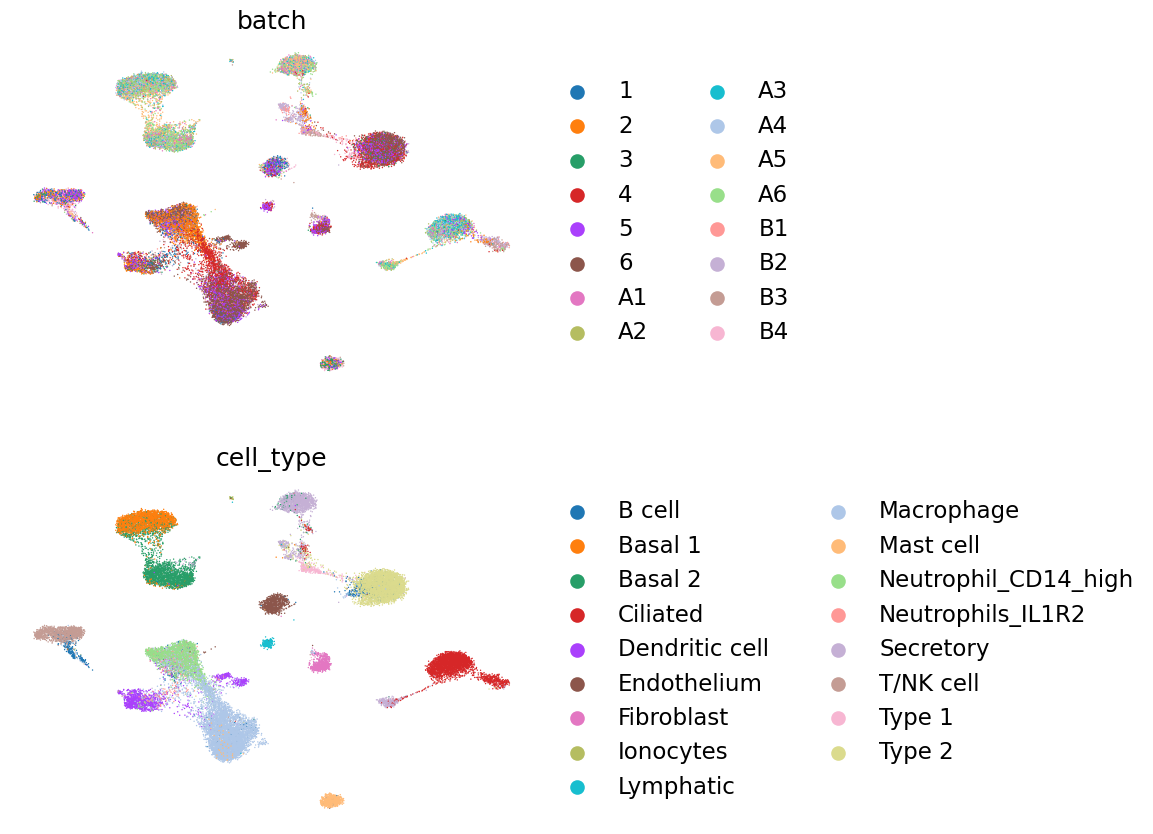

In [3]:
multi_resolution_cluster(adata, resolution1 = 1, method = 'Leiden')
VAE = train_integration_model(adata, batch_key = 'batch', z_dim=256, d_coef = 0.2)
obtain_embeddings(adata, VAE)
sc.pp.neighbors(adata, use_rep="X_scCRAFT")
sc.tl.umap(adata, min_dist=0.5)
sc.pl.umap(adata, color=["batch", "cell_type"], frameon=False, ncols=1)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 273/273: 100%|██████████| 273/273 [09:08<00:00,  1.98s/it, v_num=1, train_loss_step=773, train_loss_epoch=767]

`Trainer.fit` stopped: `max_epochs=273` reached.


Epoch 273/273: 100%|██████████| 273/273 [09:08<00:00,  2.01s/it, v_num=1, train_loss_step=773, train_loss_epoch=767]


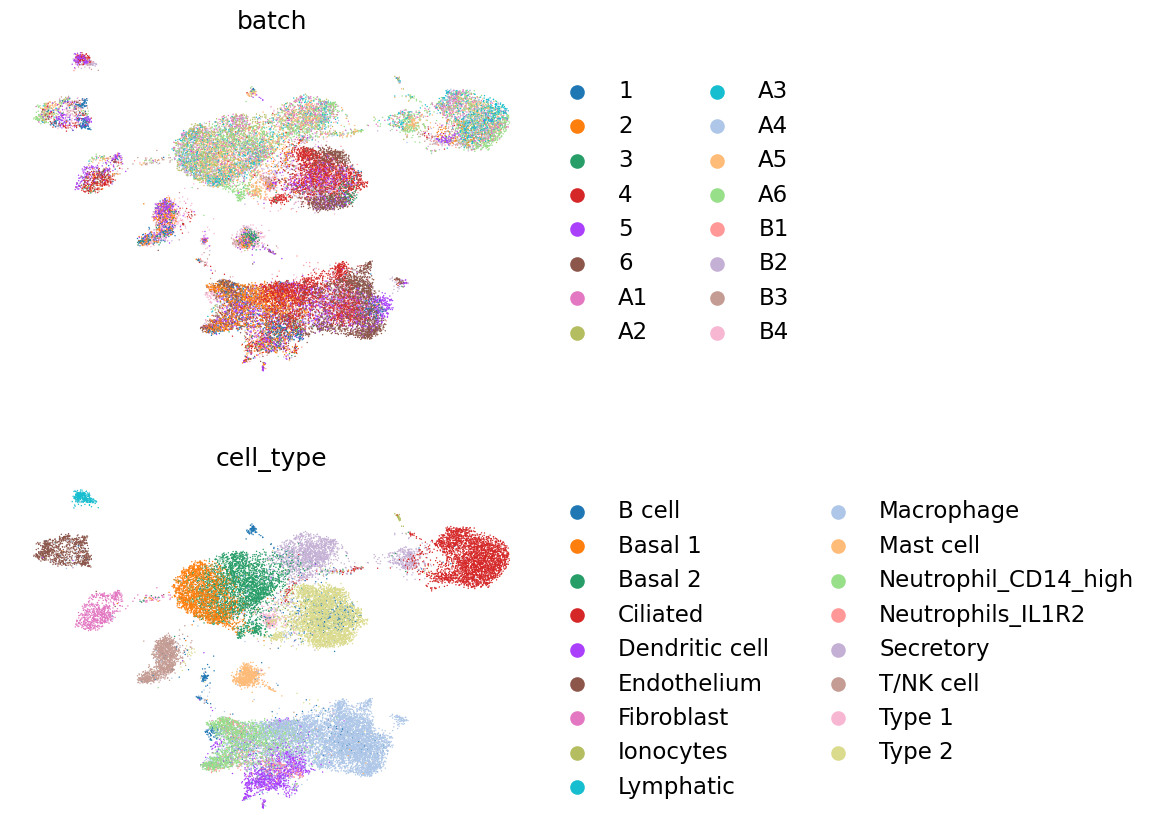

In [4]:
# scVI
adata = adata.copy()
adata.layers['counts'] = adata.X
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="batch") 
vae = scvi.model.SCVI(adata, n_layers=2, n_latent=50, gene_likelihood="nb")
vae.train()
adata.obsm["X_scVI"] = vae.get_latent_representation()
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.5)
sc.pl.umap(adata, color=["batch", "cell_type"], frameon=False, ncols=1)

2024-04-27 12:08:56,125 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-04-27 12:09:02,987 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-04-27 12:09:03,059 - harmonypy - INFO - Iteration 1 of 10
2024-04-27 12:09:07,857 - harmonypy - INFO - Iteration 2 of 10
2024-04-27 12:09:12,567 - harmonypy - INFO - Iteration 3 of 10
2024-04-27 12:09:17,145 - harmonypy - INFO - Iteration 4 of 10
2024-04-27 12:09:21,749 - harmonypy - INFO - Converged after 4 iterations


Training completed in 25.66 seconds


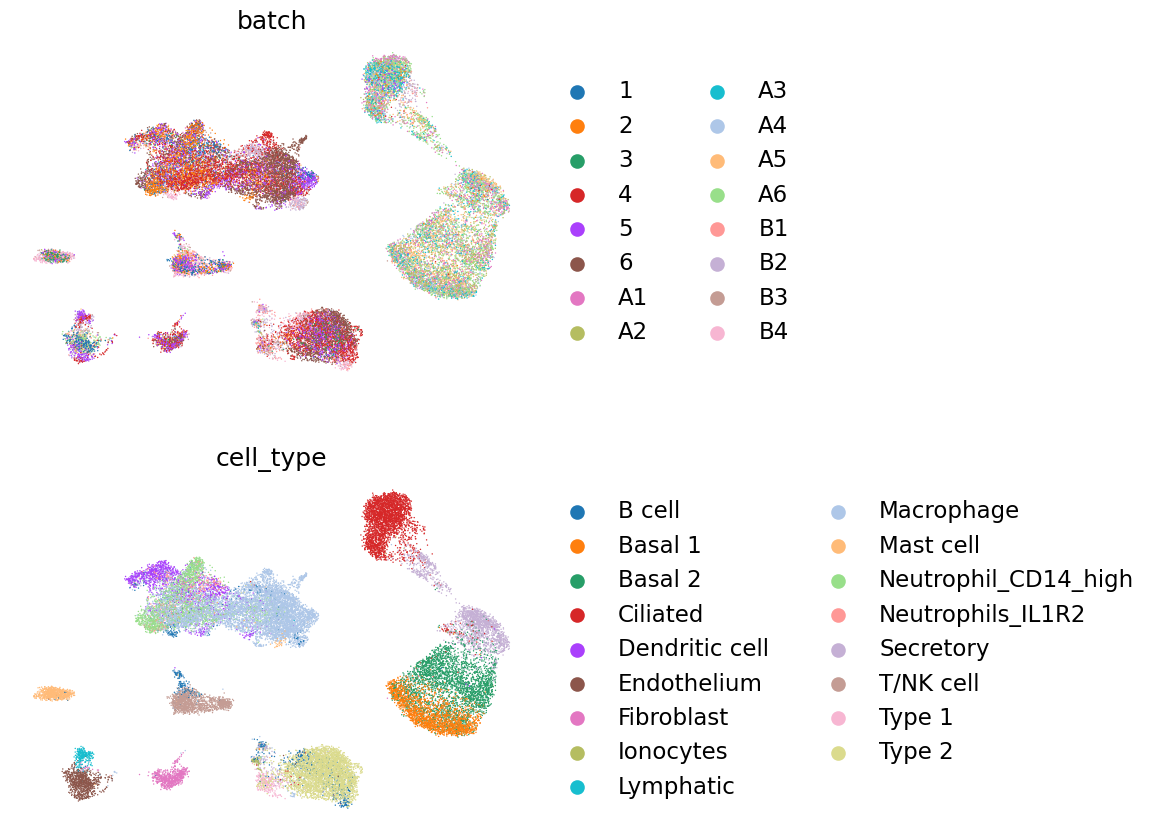

In [5]:
# Harmony
sc.tl.pca(adata, n_comps=50)
data_mat = adata.obsm['X_pca']
meta_data = adata.obs

# Specify the variables to use (as in your original code)
vars_use = ['batch']

# Run Harmony
start_time = time.time() 
ho = hm.run_harmony(data_mat, meta_data, vars_use)
end_time = time.time()
training_time = end_time - start_time
print(f"Training completed in {training_time:.2f} seconds")

# Convert the adjusted PCs to a DataFrame
res = pd.DataFrame(ho.Z_corr)
res.columns = ['X{}'.format(i + 1) for i in range(res.shape[1])]

# If you want to store the adjusted PCs back into the AnnData object
adata.obsm['X_harmony'] = res.values.T
sc.pp.neighbors(adata, use_rep="X_harmony")
sc.tl.umap(adata, min_dist=0.5)
sc.pl.umap(adata, color=["batch", "cell_type"], frameon=False, ncols=1)

Found 2000 genes among all datasets
[[0.00000000e+00 5.48672566e-01 2.66592920e-01 1.72566372e-01
  3.83849558e-01 1.68141593e-01 1.65929204e-02 6.19469027e-02
  4.42477876e-03 1.41843972e-03 2.21238938e-03 6.63716814e-03
  3.20796460e-02 3.98230088e-02 9.07079646e-02 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 5.97402597e-01 2.58048290e-01
  3.65694165e-01 4.17505030e-01 4.22535211e-02 3.92354125e-02
  4.07830343e-03 2.41134752e-02 2.06237425e-02 8.04828974e-03
  4.30916553e-02 3.37292162e-02 3.60360360e-02 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 2.51082251e-01
  7.29437229e-01 6.40692641e-01 1.51515152e-02 3.03030303e-02
  8.65800866e-03 8.65800866e-03 2.16450216e-02 4.32900433e-03
  1.29870130e-02 1.08225108e-02 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  2.14375788e-01 3.51581185e-01 2.05962060e-02 1.03163686e-02
  4.07830343e-03 5.67375887e-03 2.24438903e-02 6.37788998e-03
  1.91518468e-02 6.17577197e-03

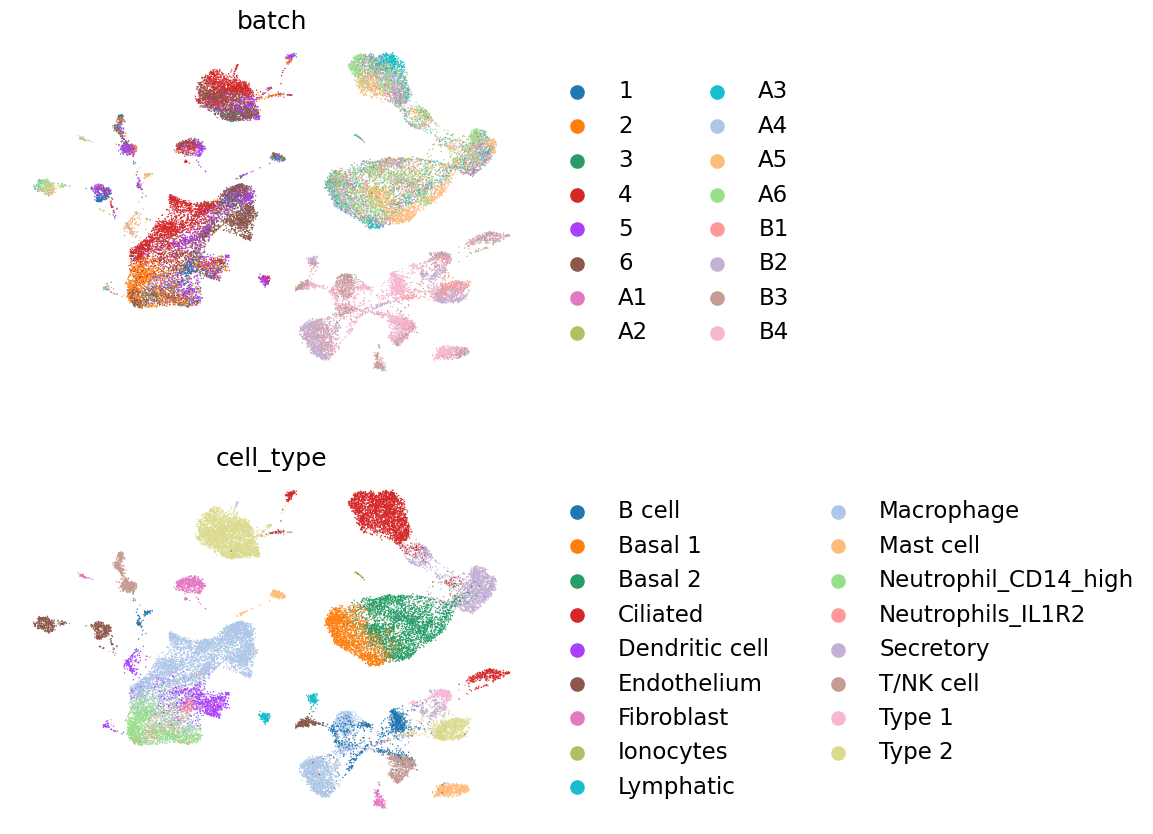

In [6]:
#Scanorama
# Save original order of cells
original_order = adata.obs_names.copy()

# Start timer
start_time = time.time()

# Your existing Scanorama correction process
split, categories = split_batches(adata.copy(), 'batch', return_categories=True)
corrected = scanorama.correct_scanpy(split, return_dimred=True)
corrected = anndata.AnnData.concatenate(
    *corrected, batch_key='batch', batch_categories=categories, index_unique=None
)

# Reorder corrected data to match original order
corrected = corrected[original_order]

# End timer
end_time = time.time()
training_time = end_time - start_time
print(f"Training completed in {training_time:.2f} seconds")

# Replace adata with corrected data
adatas = corrected.copy()

adata.obsm['X_scanorama'] = adatas.obsm['X_scanorama']

# Proceed with your analysis (neighbors, UMAP, plotting)
sc.pp.neighbors(adata, n_pcs=30, use_rep="X_scanorama")
sc.tl.umap(adata)
sc.pl.umap(adata, color=["batch", "cell_type"], frameon=False, ncols=1)

Training completed in 6.50 seconds


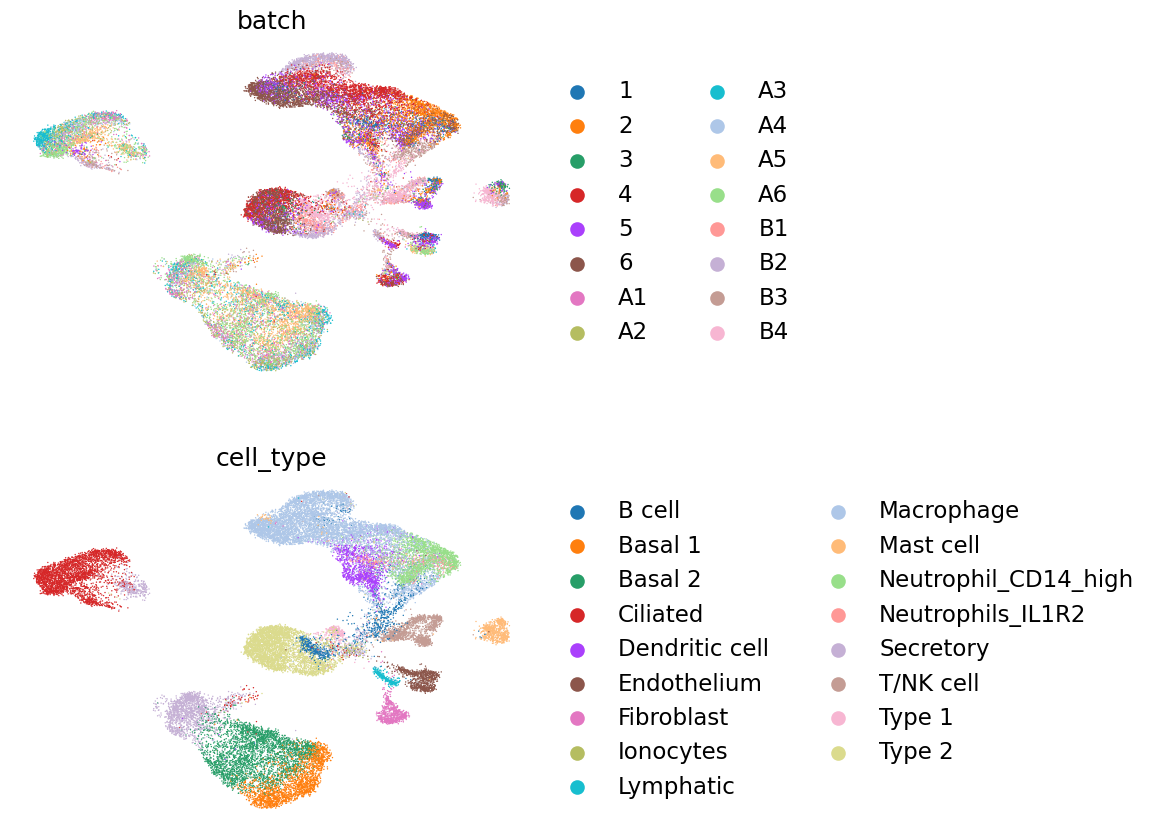

In [7]:
start_time = time.time() 
bbknn.bbknn(adata, batch_key='batch')
end_time = time.time()
training_time = end_time - start_time
print(f"Training completed in {training_time:.2f} seconds")
sc.tl.umap(adata, min_dist=0.5)
sc.pl.umap(adata, color=["batch", "cell_type"], frameon=False, ncols=1)
adata.obsm['X_bbknn'] = adata.obsm['X_umap']

HI
Step 1: Calibrating Celltype...
[Epoch 1/50] [Reconstruction loss: 0.301651] [Cotent loss: 0.003833]
[Epoch 2/50] [Reconstruction loss: 0.289609] [Cotent loss: 0.001716]
[Epoch 3/50] [Reconstruction loss: 0.286349] [Cotent loss: 0.001501]
[Epoch 4/50] [Reconstruction loss: 0.254263] [Cotent loss: 0.001683]
[Epoch 5/50] [Reconstruction loss: 0.229672] [Cotent loss: 0.001015]
[Epoch 6/50] [Reconstruction loss: 0.224964] [Cotent loss: 0.000784]
[Epoch 7/50] [Reconstruction loss: 0.223803] [Cotent loss: 0.000607]
[Epoch 8/50] [Reconstruction loss: 0.221608] [Cotent loss: 0.000621]
[Epoch 9/50] [Reconstruction loss: 0.215378] [Cotent loss: 0.000755]
[Epoch 10/50] [Reconstruction loss: 0.208857] [Cotent loss: 0.000453]
[Epoch 11/50] [Reconstruction loss: 0.202609] [Cotent loss: 0.000411]
[Epoch 12/50] [Reconstruction loss: 0.199465] [Cotent loss: 0.000435]
[Epoch 13/50] [Reconstruction loss: 0.197156] [Cotent loss: 0.000400]
[Epoch 14/50] [Reconstruction loss: 0.192762] [Cotent loss: 0.00

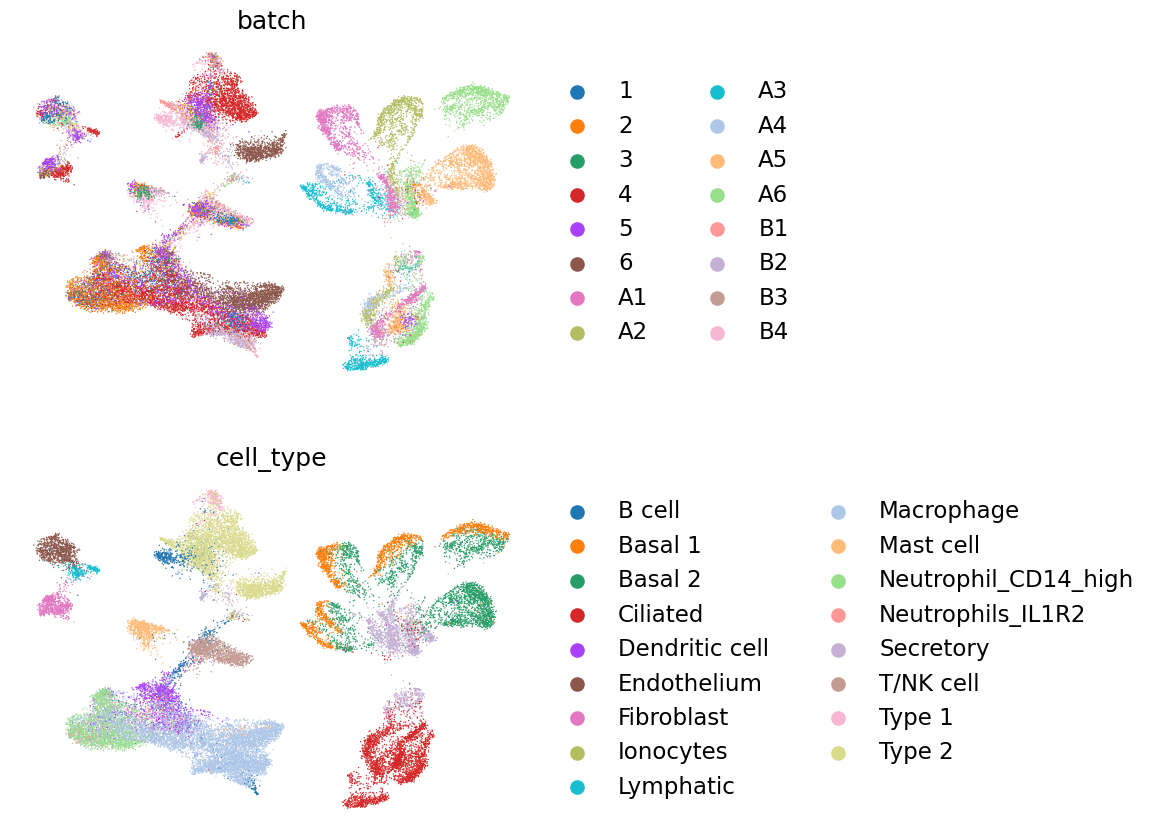

In [8]:
#iMAP

if type(adata.X) != type(np.array([])):
    adata.X = adata.X.toarray()
start_time = time.time() 
### Stage I
print('HI')
EC, ec_data = imap.stage1.iMAP_fast(adata, key='batch', n_epochs=50)
### Stage II
output_results = imap.stage2.integrate_data(adata, ec_data, key='batch', n_epochs=40)
output_results.shape
end_time = time.time()
print('total time talken', end_time-start_time)
adata_int = adata.copy()
adata_int.X = output_results

sc.tl.pca(adata_int, n_comps=50)
sc.pp.neighbors(adata_int, use_rep="X_pca")
sc.tl.umap(adata_int, min_dist=0.5)
sc.pl.umap(adata_int, color=["batch", "cell_type"], frameon=False, ncols=1)
adata.obsm['imap'] = adata_int.obsm['X_pca']

2024-04-27 12:28:01,522 - root - INFO - Create log file....
2024-04-27 12:28:01,523 - root - INFO - Create scDMLModel Object Done....
2024-04-27 12:28:01,794 - root - INFO - Running preprocess() function...
2024-04-27 12:28:01,795 - root - INFO - mode=unsupervised
2024-04-27 12:28:01,795 - root - INFO - clustering method=louvain
2024-04-27 12:28:01,795 - root - INFO - resolution=3.0
2024-04-27 12:28:01,796 - root - INFO - BATCH_key=batch
2024-04-27 12:28:01,796 - root - INFO - Normalize counts per cell(sum=10000.0)
2024-04-27 12:28:01,857 - root - INFO - Log1p data


2024-04-27 12:28:01,900 - root - INFO - Select HVG(n_top_genes=1000)
2024-04-27 12:28:02,648 - root - INFO - Scale batch(scale_value=10.0)
2024-04-27 12:28:02,815 - root - INFO - Calculate PCA(n_comps=100)


         Falling back to preprocessing with `sc.pp.pca` and default params.


2024-04-27 12:28:08,897 - root - INFO - Apply louvain clustring(resolution=3.0) initization
2024-04-27 12:28:08,899 - root - INFO - Number of Cluster =46
2024-04-27 12:28:08,900 - root - INFO - clusters=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45]
2024-04-27 12:28:08,901 - root - INFO - Preprocess Dataset Done...
2024-04-27 12:28:08,902 - root - INFO - mode=unsupervised
2024-04-27 12:28:08,942 - root - INFO - K_in=5,K_bw=10
2024-04-27 12:28:08,943 - root - INFO - Calculate similarity of cluster with KNN and MNN
2024-04-27 12:28:08,943 - root - INFO - appoximate calculate KNN Pair intra batch...
2024-04-27 12:28:08,946 - root - INFO - Calculate KNN pair intra batch...........
2024-04-27 12:28:08,946 - root - INFO - K=5
2024-04-27 12:28:08,947 - root - INFO - metric=cosine
2024-04-27 12:28:08,947 - root - INFO - Processing datasets: (0, 0) = (1, 1)
2024-04-27 

time taken to run : 56.44682431221008


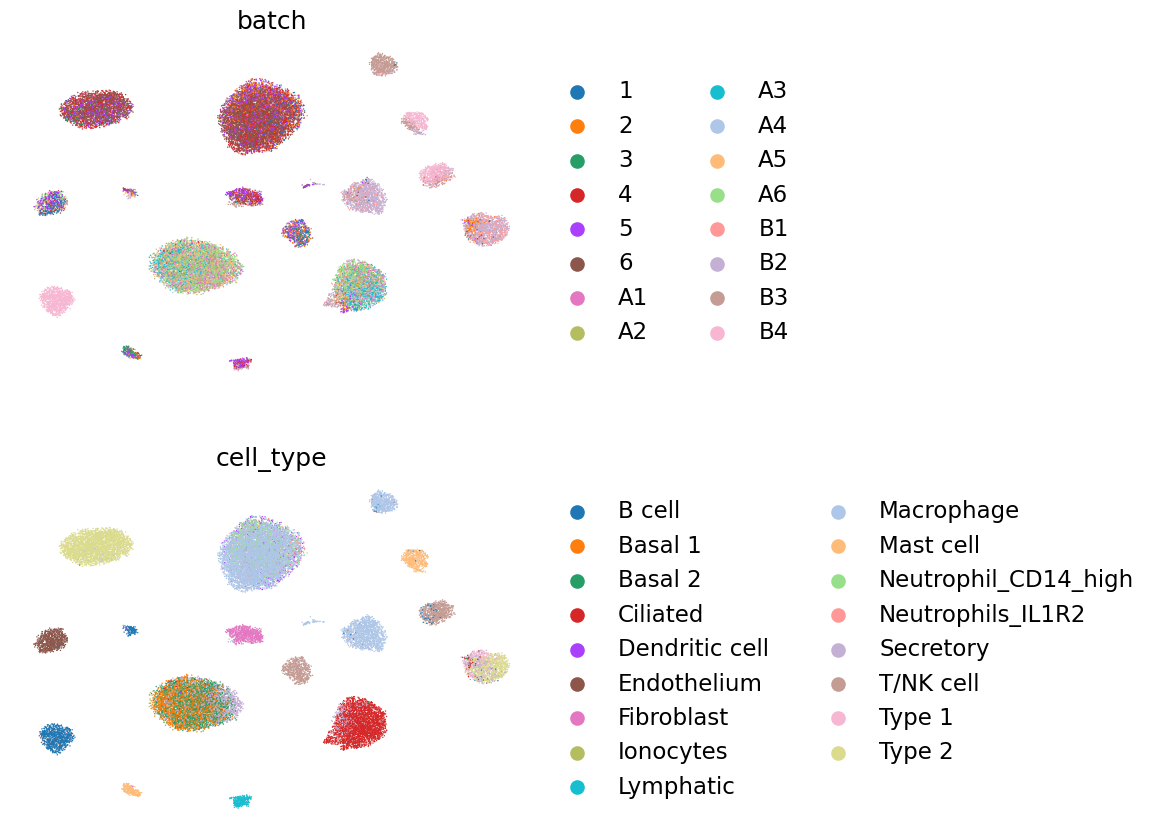

In [9]:
#scDML

start_time = time.time()
ncluster = len(adata.obs['cell_type'].unique())
scdml=scDMLModel()
adata_int = adata.copy()
adata_int=scdml.preprocess(adata_int, cluster_method="louvain",resolution=3.0,batch_key = 'batch')
scdml.integrate(adata_int,batch_key='batch',ncluster_list=[ncluster],
               expect_num_cluster=ncluster,merge_rule="rule2", out_dim=50)
end_time = time.time()
print('time taken to run :', end_time - start_time)
adata.obsm['scDML'] = adata_int.obsm['X_emb']
sc.pp.neighbors(adata, use_rep='scDML')
sc.tl.umap(adata)
sc.pl.umap(adata, color=["batch", "cell_type"], frameon=False, ncols=1)

In [10]:
# Seurat R pipeline
```R
library(Seurat)
library(anndata)
library(reticulate)
library(SeuratWrappers)
library(SeuratDisk)

Convert('/path/Lung_atlas_raw.h5ad', "h5seurat", assay = "RNA",
        overwrite = T, verbose = T)
seurat_obj <- LoadH5Seurat("/path/Lung_atlas_raw.h5seurat", assay = "RNA", meta.data = T)
saveRDS(seurat_obj, file = "/path/Lung_atlas_raw.rds")  

seurat_obj = readRDS("/path/Lung_atlas_raw.rds")
original_cell_order <- colnames(seurat_obj@assays$RNA@counts)
seurat_obj[["RNA"]] <- split(seurat_obj[["RNA"]], f = seurat_obj$batch)
seurat_obj <- SCTransform(seurat_obj)
seurat_obj <- RunPCA(seurat_obj, npcs = 50, verbose = F)
seurat_obj <- IntegrateLayers(
  object = seurat_obj, method = RPCAIntegration,
  new.reduction = "integrated.rpca", normalization.method = "SCT",
  verbose = FALSE
)

integrated_rpca_embeddings <- Embeddings(object = seurat_obj, reduction = "integrated.rpca")
pca_embeddings <- integrated_rpca_embeddings[, 1:50]
pca_embeddings_ordered <- pca_embeddings[match(original_cell_order, rownames(pca_embeddings)), ]
write.csv(pca_embeddings_ordered, file = "/path/Lung_atlas_seurat.csv", row.names = TRUE)
```

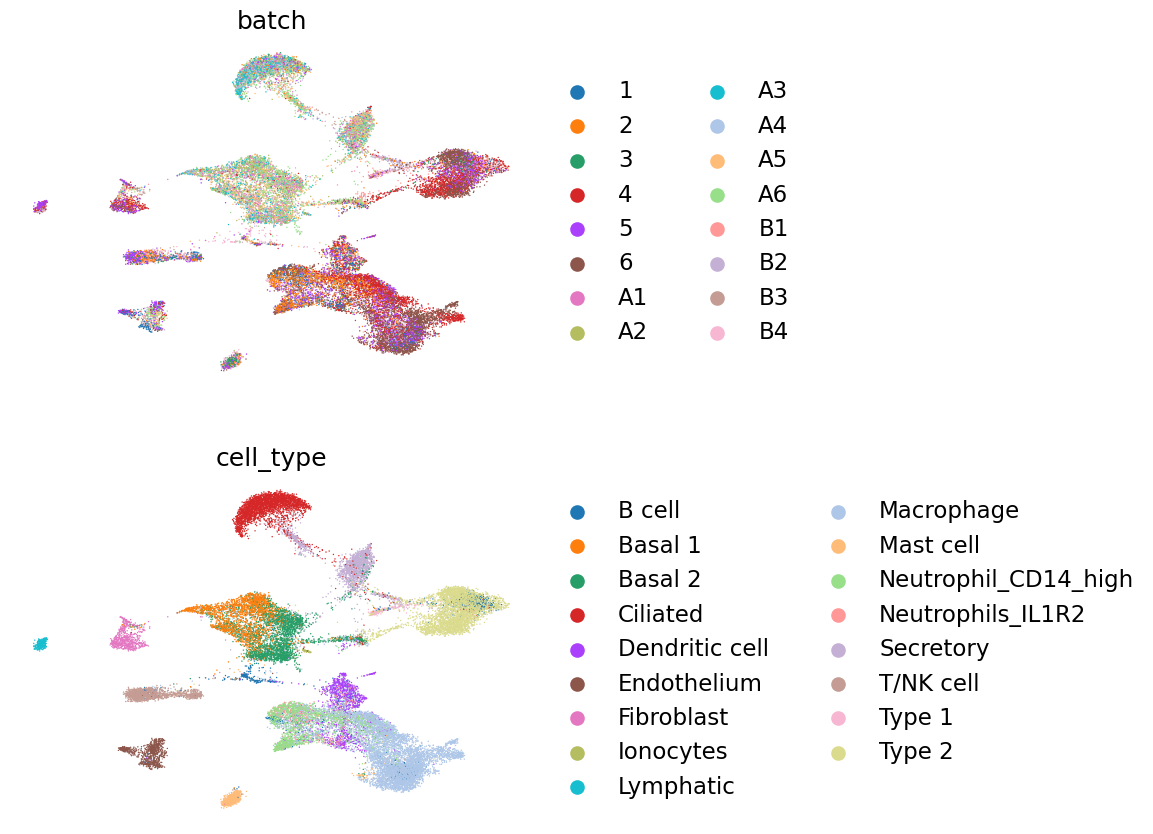

In [12]:
pca_embeddings = pd.read_csv('/path/Lung_atlas_seurat.csv', index_col=0)
adata.obsm['X_seurat'] = pca_embeddings.values
sc.pp.neighbors(adata, use_rep="X_seurat")
sc.tl.umap(adata, min_dist=0.5)
sc.pl.umap(adata, color=["batch", "cell_type"], frameon=False, ncols=1)